There is a typo in the course notebook, namely they took 'ram' for filling null values instead of 'screen'.

Also, I'm doing log-exponentiate procedure of the target + I do not regularize the intercept.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../hw01/laptops.csv")

df.columns = df.columns.str.lower().str.replace(" ", "_")

df = df[["ram", "storage", "screen", "final_price"]]
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


<Axes: >

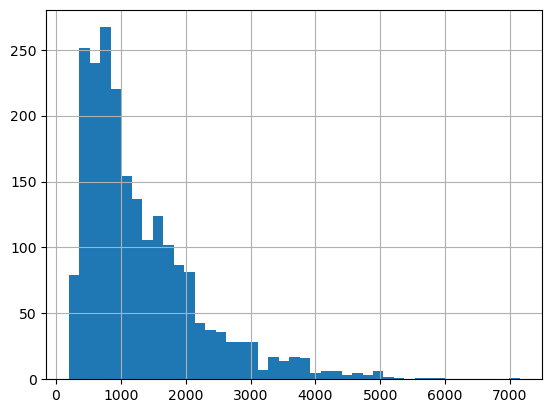

In [72]:
df["final_price"].hist(bins=len(df) // 50)

<Axes: >

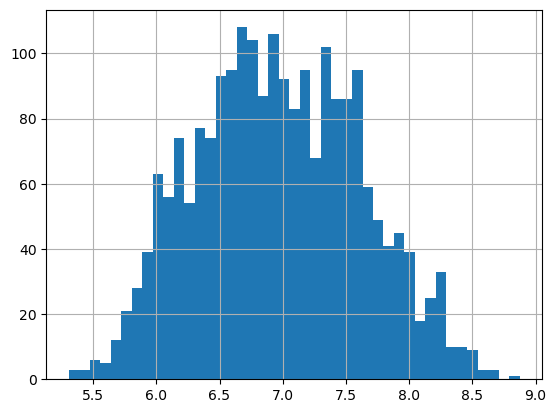

In [149]:
np.log1p(df["final_price"]).hist(bins=len(df) // 50)

Question 1

In [73]:
n_nulls = df.isnull().sum()
n_nulls[n_nulls != 0]

screen    4
dtype: int64

Question 2

In [74]:
df["ram"].median()

np.float64(16.0)

Prepare and split the dataset

In [3]:
n_val = n_test = int(len(df) * 0.2)
n_train = len(df) - n_val - n_test

In [4]:
rng = np.random.default_rng(seed=42)

idx = list(df.index)
rng.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train : n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val :]]

len(df_train), len(df_val), len(df_test)

(1296, 432, 432)

Question 3

In [69]:
y_train = np.log1p(df_train["final_price"])
X_train = df_train.drop(["final_price"], axis=1)

y_val = np.log1p(df_val["final_price"])
X_val = df_val.drop(["final_price"], axis=1)

In [123]:
def linear_regression(X, y, r=0):
    x_0 = np.ones(len(X))
    X = np.column_stack([x_0, X])
    XTX = X.T @ X
    regularization_matrix = np.eye(len(XTX))
    regularization_matrix[0][0] = 0  # do not regularize intercept
    XTX = XTX + r * regularization_matrix
    intercept, *weights = np.linalg.inv(XTX).dot(X.T).dot(y)

    return intercept, weights


def rmse(y_pred, y_test):
    errors = y_pred - y_test
    mse = np.pow(errors, 2).mean()
    rmse = np.sqrt(mse)
    return round(rmse, 2)

In [124]:
# with filling by zeros
w_0, weights = linear_regression(X_train.fillna(0), y_train)
y_val_predicted = np.expm1(w_0 + X_val.fillna(0).dot(weights))

rmse(y_val_predicted, y_val)

np.float64(4147.95)

In [125]:
# with filling by train mean
w_0, weights = linear_regression(X_train.fillna(X_train.screen.mean()), y_train)
y_val_predicted = np.expm1(w_0 + X_val.fillna(X_train.screen.mean()).dot(weights))

rmse(y_val_predicted, y_val)

np.float64(4172.87)

Question 4

In [141]:
for reg_coef in (0, 0.01, 1, 10, 100):
    w_0, weights = linear_regression(X_train.fillna(0), y_train, r=reg_coef)
    y_val_predicted = np.expm1(w_0 + X_val.fillna(0).dot(weights))

    print(f"{reg_coef}: {rmse(y_val_predicted, y_val)}")

0: 4147.95
0.01: 4147.95
1: 4147.72
10: 4145.57
100: 4124.44


Question 5

In [168]:
rmse_results = []

for rng_seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    rng = np.random.default_rng(seed=rng_seed)

    idx = list(df.index)
    rng.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train : n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val :]]

    y_train = np.log1p(df_train["final_price"])
    X_train = df_train.drop(["final_price"], axis=1)

    y_val = np.log1p(df_val["final_price"])
    X_val = df_val.drop(["final_price"], axis=1)

    w_0, weights = linear_regression(X_train.fillna(0), y_train)
    y_val_predicted = np.expm1(w_0 + X_val.fillna(0).dot(weights))

    rmse_score = rmse(y_val_predicted, y_val)
    rmse_results.append(rmse_score)

    print(f"{rng_seed}: {rmse_score}")

0: 3259.03
1: 1719.83
2: 1765.09
3: 1274.39
4: 5039.87
5: 2450.01
6: 1778.84
7: 2958.3
8: 1807.35
9: 1544.29


In [169]:
np.array(rmse_results).std()

np.float64(1077.3513043199976)

Question 6

In [170]:
rng = np.random.default_rng(seed=9)

idx = list(df.index)
rng.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train : n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val :]]

y_train = np.log1p(df_train["final_price"])
X_train = df_train.drop(["final_price"], axis=1)

y_val = np.log1p(df_val["final_price"])
X_val = df_val.drop(["final_price"], axis=1)

y_test = np.log1p(df_test["final_price"])
X_test = df_test.drop(["final_price"], axis=1)

w_0, weights = linear_regression(
    np.vstack([X_train.fillna(0), X_val.fillna(0)]),
    np.hstack([y_train, y_val]),
    r=0.001,
)
y_test_predicted = np.expm1(w_0 + X_test.fillna(0).dot(weights))

rmse(y_test_predicted, y_test)

np.float64(1811.67)